# Overview

The code presented below was used to calculate 95% confidence intervals around Cumulative Incidence Functions for using Stata's stcurve command for a competing risks estimation regression (stcrreg).  

Figure 1 in our paper shows two CIFs -- one with 0 UN Troops and one with ~10,000 UN Troops. To produce first differences in these curves we employ a bootstrap approach. 

Namely, in this approach we follow Jacob Aronson's advice to:

>"Re-sample the data, produce predictions for the values you want to compare and compute the first difference. In the case of a CR model, predict the CIF for the two different values of the variable and take the difference."

Given that we have clustered time series data, we need to use a *block bootstrap*. Below we present the Python and Stata code we used to generate the first differences shown produce Figure 2.



##### Brief overview of algorithm

Because *stcurve* has no confidence intervals in Stata, we need to generate these intervals using a bootstrap technique. Moreover, because we are dealing with time series data, we need to employ a *block bootstrapping* procedure. Because there are no block bootstrapping capabilities in Stata, we generated 1,000 block bootstrap samples in Python, then wrote a loop in Stata to run our *stcrreg* and *stcurve* code 1,000 times -- in each loop we run our regression code (*stcrreg*) and calculate the CIF curves via the *stcurve* command and save the *stcurve* output. We then used Python to aggregate the 1,000 output files and generate the graph now shown in the paper as Figure 2.

# Import Python Packages

First, we will import several necessary Python packages. We will be using the <a href="http://pandas.pydata.org/">Python Data Analysis Library,</a> or <i>PANDAS</i>, extensively for our data manipulations. It is invaluable for analyzing datasets. 

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series

In [2]:
# http://pandas.pydata.org/pandas-docs/stable/options.html
pd.set_option('display.max_columns', None)
# http://pandas.pydata.org/pandas-docs/stable/options.html
pd.set_option('display.max_colwidth', 250)

<br>Set working directory

In [1]:
cd '/Users/mbenson2/Downloads/'

# Read in Stata Dataset
Here we read in a version of our dataset that is generated via the *e(sample)==1* procedure in *Stata* after running the following *stcrreg* regression for Table 2, Model 1.

~~~html
gen dyadterm_PA_CF = 0
replace dyadterm_PA_CF = 1 if dyadterm == 1 & (outcome == 1 | outcome == 2)
replace dyadterm_PA_CF = 2 if dyadterm == 1 & (outcome == 3 | outcome == 4  | outcome == 5 | outcome == 6)
stset warduration, failure(dyadterm_PA_CF==1) id(dyadep)

*Table 2, Model 1
stcrreg lntroopLag lnpoliceLag lnmilitaryobserversLag lnbrv_civAggLag lnbrv_abAggLag lntpop contestnumber rebstrength numofrebgroups_gwnoaLag incompatibility demdum biased_rebintervLag biased_govintervLag if (regionAfr==1 | regionME == 1 | regionAsia==1), compete(dyadterm_PA_CF==2) cl(gwnoa) nohr

keep if e(sample)==1
~~~

In [146]:
df = pd.read_csv('JCR_no_missing.csv')
print '# of columns:', len(df.columns)
print '# of observations:', len(df)
df[:2]

# of columns: 17
# of observations: 7782


,warduration,dyadterm_PA_CF,dyadep,lntroopLag,lnpoliceLag,lnmilitaryobserversLag,lnbrv_civAggLag,lnbrv_abAggLag,lntpop,contestnumber,rebstrength,numofrebgroups_gwnoaLag,incompatibility,demdum,biased_rebintervLag,biased_govintervLag,gwnoa
0,7,0,101,0.0,0.0,0.0,0.693147,4.356709,10.176259,1,2.0,2.0,2,0,0.0,0.0,615
1,8,0,101,0.0,0.0,0.0,1.098612,4.634729,10.176259,1,2.0,2.0,2,0,0.0,0.0,615


# Create 1,000 Bootstrap Samples
The following code block re-samples the data 1,000 times using a block bootstrapping procedure. Here we are using *circular block* bootstrapping procedure with block length of 19. The 1,000 files are saved in *Stata* format to a chosen directory.

In [148]:
from arch.bootstrap import CircularBlockBootstrap
bs = CircularBlockBootstrap(19, df)
counter = 0
for data in bs.bootstrap(1000):
    counter +=1
    dfb = data[0][0]
    dfb = dfb.reset_index()
    dfb = dfb.groupby('index').first()
    dfb.to_stata('JCR_bootstrap/bs%s.dta' % counter)

# Go to Stata and Run *stcrreg* and *stcurve* Code
In Stata we are now going to loop over the 1,000 bootstrap datasets saved in the previous step. First, install *filelist* if needed.

~~~html
ssc install filelist

~~~

<br>Now, run the following line in Stata to search for all <i>*.dta</i> files in your *JCR_bootstrap* directory and save the output to disk.

~~~html
filelist , dir("/Users/mbenson2/Downloads/JCR_bootstrap") pat("*.dta") save("/Users/mbenson2/Downloads/dta_datasets.dta")

~~~

<br>
Now we can run our core loop. In the following *Stata* code we are looping over the 1,000 files in turn. For each one, we apply *stset*, we run our *stcrreg* command following by *stcurve*, which plots the two chosen CIFs. At the same time, we save the data generated by *stcurve* to an outfile with names *df1.dta* to *df1000.dta*

~~~html

forvalues i=1/1000{
    use "/Users/mbenson2/Downloads/dta_datasets.dta" in `i', clear
    local f = dirname + "/" + filename
    *insheet using "`f'", clear
	use "`f'", clear
    
	stset warduration, failure(dyadterm_PA_CF==1) id(dyadep)
    
    quietly stcrreg lntroopLag lnpoliceLag lnmilitaryobserversLag lnbrv_civAggLag lnbrv_abAggLag lntpop contestnumber rebstrength numofrebgroups_gwnoaLag incompatibility demdum biased_rebintervLag biased_govintervLag, compete(dyadterm_PA_CF==2) cl(gwnoa) nohr
    
    gen source = "`f'"
    tempfile save`i' 
    save "`save`i''"

    stcurve, cif at1(lntroopLag=0 lnpoliceLag=.415 lnmilitaryobserversLag=.449 lnbrv_civAggLag=3.029 lnbrv_abAggLag=5.697 lntpop=10.611 contestnumber=1 rebstrength=2 numofrebgroups_gwnoaLag=7 incompatibility=2 demdum=0 biased_rebintervLag=0 biased_govintervLag=0) at2(lntroopLag=9.2 lnpoliceLag=.415 lnmilitaryobserversLag=.449 lnbrv_civAggLag=3.029 lnbrv_abAggLag=5.697 lntpop=10.611 contestnumber=1 rebstrength=2 numofrebgroups_gwnoaLag=7 incompatibility=2 demdum=0 biased_rebintervLag=0 biased_govintervLag=0) title("") xtitle("") ytitle("") xlabel(0(20)100) range(0 100) xscale(range(0 100) noextend)  legend(label(1 "UN Troops (ln)=0") label(2 "UN Troops (ln)=9.2 (ie ~10,000 troops)")) outfile("/Users/mbenson2/Downloads/stcurve_saves/df`i'")
    
 }
~~~

# Aggregate stcurve Output in Python
We have 1,000 datasets saved in our folder *stcurve_saves*. Let's change our working directory to this folder and then read in the first one.

In [2]:
cd '/Users/mbenson2/Downloads/stcurve_saves'

In [154]:
dfo = pd.read_stata('df1.dta')
print '# of columns:', len(dfo.columns)
print '# of observations:', len(dfo)
dfo[:5]

# of columns: 3
# of observations: 3923


,ci2,ci3,_t
0,0.007575,0.088778,1
1,0.007575,0.088778,1
2,0.007575,0.088778,1
3,0.007575,0.088778,1
4,0.007575,0.088778,1


<br>
*stcurve* generates a graph based on 100 unique observations ranging from t0 to t100. The output file, however, has many duplicates, as you can see with the first five observations for t1. We only need the first observation at each of the 100 time points. We will get rid of the duplicate observations using the following code block. At the same time, we will also create a new column that is the difference between the CIF values at each of the 100 time points.

In [155]:
dfo = dfo.groupby('_t').agg({'ci2': {'ci2': 'first'},'ci3': {'ci3': 'first'}})
print len(dfo)
dfo.columns = dfo.columns.droplevel(0)
dfo['diff'] = dfo['ci3'] - dfo['ci2']
print '# of observations:', len(dfo)
dfo[:2]

100
# of observations: 100


,ci3,ci2,diff
_t,,,
1,0.088778,0.007575,0.081204
2,0.299922,0.028740,0.271182


<br>Now we will loop over the remaining 999 *stcurve* outfiles. For each one, we will drop duplicate values, create our *diff* column, and then append the file to the end of our dataframe *dfo*. We end up a dataset with 100,000 observations, which represents the 100 CIF time points (t1 to t100) for our 1,000 bootstrap samples.

In [157]:
for x in range(1,1000,1):
    #print x
    df = pd.read_stata('df%s.dta' % x)
    #print len(df)
    df = df.groupby('_t').agg({'ci2': {'ci2': 'first'},'ci3': {'ci3': 'first'}})
    df.columns = df.columns.droplevel(0)
    df['diff'] = df['ci3'] - df['ci2']
    #print len(df)
    dfo = dfo.append(df)
    #print len(dfo)

print len(dfo)
dfo = dfo.reset_index()
dfo[:2]

100000


,_t,ci3,ci2,diff
0,1,0.088778,0.007575,0.081204
1,2,0.299922,0.028740,0.271182


### Collapse the Data
We will now collapse the above data -- for each of the 100 time points we will generate the mean value and the standard deviation for the first difference. First, in the following block of code, we create a 'dictionary' of aggregation operations.

In [159]:
# CREATE DICTIONARY OF AGGREGATION OPERATIONS
aggregations = {
    'ci2': {'ci2_mean': 'mean', 'ci2_std': 'std'},
    'ci3': {'ci3_mean': 'mean', 'ci3_std': 'std'},
    'diff': {'diff_mean': 'mean', 'diff_std': 'std'},    
    }

<br>Then in the following code block we collapse our dataframe *dfo*, in the process applying the above-specified *mean* and *standard deviation* aggregations and also creating columns indicating the upper and lower bounds of the 95% confidence interval of the first differences.

In [160]:
dfx = dfo.groupby('_t').agg(aggregations)
print len(dfx)
dfx.columns = dfx.columns.droplevel(0)
dfx['ci_upper'] = dfx['diff_mean']+1.96*dfx['diff_std']
dfx['ci_lower'] = dfx['diff_mean']-1.96*dfx['diff_std']
print '# of observations:', len(dfx)
dfx[:2]

100
# of observations: 100


,ci3_mean,ci3_std,ci2_mean,ci2_std,diff_mean,diff_std,ci_upper,ci_lower
_t,,,,,,,,
1,0.089330,0.113137,0.007564,0.00367,0.081766,0.112292,0.301858,-0.138325
2,0.229626,0.181054,0.024249,0.00755,0.205377,0.180680,0.559510,-0.148755


# Plot the First Differences with Confidence Intervals
Here we will use Python's built-in plotting capabalities (*matplotlib*) supplemented by the *seaborn* package. The following five code blocks are simply package imports and setting a default plot size.

In [161]:
import matplotlib
print matplotlib.__version__
import matplotlib.pyplot as plt
#NECESSARY FOR XTICKS OPTION, ETC.
from pylab import*

2.2.2


In [162]:
%matplotlib inline 

In [163]:
import seaborn as sns
print sns.__version__

0.8.1


In [164]:
plt.rcParams['figure.figsize'] = (15, 7.5)

In [ ]:
mpl.style.use('grayscale')
sns.set_style("whitegrid")

### Generate Plot and Save Output
We now generate Figure 2. To recap, this shows the sdifference in expected CIF curves with ~10,000 UN Troops and 0 UN Troops. Specifically, the graph below shows the mean difference in the CIF curves shown in Figure 1, with 95% confidence intervals, based on block bootstrapping with 1,000 tests.

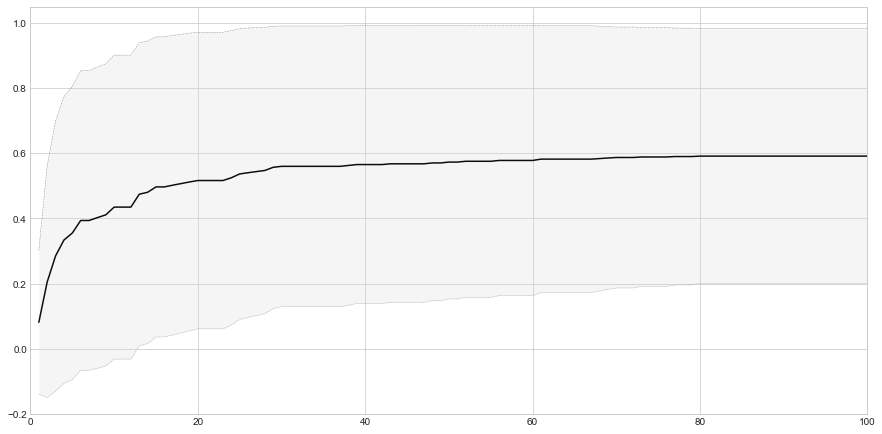

In [169]:
plt.plot(dfx.index, dfx['diff_mean'], linestyle="-", linewidth=1.5, alpha=0.95)
plt.plot(dfx.index, dfx['ci_upper'], linestyle="--", linewidth=.5, alpha=0.75)
plt.plot(dfx.index, dfx['ci_lower'], linestyle="--", linewidth=.5, alpha=0.75)
plt.fill_between(dfx.index, dfx['ci_lower'], dfx['ci_upper'],
                alpha=.25, edgecolor='#3F7F4C', facecolor='#DBDBDB',
                linewidth=0)
plt.xlim(0,100)  #SET X-AXIS RANGE
plt.ylim(-.2,)  #SET Y-AXIS RANGE
savefig('/Users/mbenson2/Downloads/CIF differences.png', bbox_inches='tight', facecolor = 'white', dpi=600, format='png')
plt.show()